In [1]:
import time

### Input data paths:

# Gioia

In [49]:
dataset_path = "../../Bio_Project/SimDataset/reads_datasets/all_250000_1.fq"
#classifier_path = "../../Bio_Project/SimDataset/classifiers_results/strex_centrifuge_250000.res"
#classifier_path = "../../Bio_Project/SimDataset/classifiers_results/strex_kraken2_250000.res"
classifier_path = "../../Bio_Project/SimDataset/classifiers_results/strex_clark_genus_250000.res"
clusters_path =  "../../Bio_Project/results/LiME_binning_all_250000_1/all_250000_1+RC.fasta.a16.t20.txt"

IsFasta = False

TotalReassignment = True

# Leo

In [27]:
#dataset_path = "../all_118309_1.fq"
#clusters_path =  "../all_118309_1+RC.fasta.a16.t20.txt"
#classifier_path = "../strex_kraken1_118309.res"

dataset_path = "../all_250000_1.fq"
clusters_path =  "../all_250000_1+RC.fasta.a16.t20.txt"
#classifier_path = "../strex_kraken2_250000.res"
#classifier_path = "../strex_centrifuge_250000.res"
classifier_path = "../strex_kraken1_250000.res"



IsFasta = False

TotalReassignment = True

#### Load dataset function 
- If dataset is in fasta format then dataset_format parameter equals TRUE.
- If dataset is in fastq format then dataset_format equals FALSE.



In [50]:
def load_dataset(path, datset_format : bool):

    dataset = open(path, "r")
    dataset_lines = []

    if (datset_format):
        divisor = 2
    else:
        divisor = 4

    index = 0
    for line in dataset:
        if (index%divisor==0):
            read_id = line.split()[0]
            dataset_lines.append(read_id[1: len(read_id)-2])
        index = index + 1

    dataset.close()

    return dataset_lines

#### Load clusters result function

In [51]:
def load_clusters_result(path):

    clusters = open(path, "r")
    clusters_list = []

    for group in clusters:
        clusters_list.append(int(group))

    clusters.close()

    return clusters_list

#### Load classifier result function
It returns a dictionary where:

- key = read id
- value = class found by classifier

In [52]:
def load_classifier_result(path):

    classification = open(path, 'r')
    classifier_results = {}

    for line in classification:
        col = []
        for j in range(0, len(line.split())):
            col.append(line.split()[j])
        
        classifier_results[col[0]] = col[1]

    classification.close()

    return classifier_results 

#### Build dataset function
This functions creates a list of following lists:
[read_id, class, cluster]

In [53]:
def build_dataset(dataset_ids,clusters,classifier):
    final_dataset =[]
        
    for i in range(0, len(dataset_ids)):
        final_dataset.append([])

        if dataset_ids[i] in classifier:
            final_dataset[i].append(dataset_ids[i])
            final_dataset[i].append(classifier[dataset_ids[i]])
            final_dataset[i].append(clusters[i])
        else:
            final_dataset[i].append(dataset_ids[i])
            final_dataset[i].append('0')
            final_dataset[i].append(clusters[i])
        
    return final_dataset

#### Get inverted index function
This function is used to create a list for each cluster. This list represents corresponding classes

In [54]:
def get_inverted_index(clusters, dataset):

    num_clusters = max(clusters) + 1
    num_reads = len(dataset)
    inverted_index = []
    
    for i in range(0, num_clusters):
        inverted_index.append([])
   
    for i in range(0, num_reads):
        inverted_index[dataset[i][2]].append(dataset[i][1])

    return inverted_index

#### Find labels function

In [55]:
def find_labels(read_ids, classification_output):

    complete_classifier_result = []
    found : bool = False
    count = 0
    for i in range(0, len(read_ids)):
        for j in range(0, len(classification_output)):
            col = []
            if (read_ids[i] == classification_output[j][0]):
                complete_classifier_result.append(classification_output[j])
                found = True
                break
        if not found:
            count = count +1
            complete_classifier_result.append(read_ids[i], '0')

    print("count: ", count)
    print("length classification output: ", len(classification_output))
    print("length complete classification output: ", len(complete_classifier_result))

    return complete_classifier_result

#### Find labels frequency function
Given a cluster, it returns a dictionary which contains the number of occurency for each class

In [56]:
# dict --> (class, occurences)

def frequency_search(cluster):
    
    label_dict= {}
       
    for label in cluster:         
    
        if label in list(label_dict):
            label_dict[label] = label_dict[label] + 1
        else:
            # if it does not exist, it's automatically created
            label_dict[label] = 1
        
    return label_dict   

#### Basic operation functions
- intersection
- binary search
- diff
- binary search list

In [57]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3


# Iterative Binary Search Function
# It returns index of x in given array arr if present,
# else returns -1
def binary_search(arr, x):
    low = 0
    high = len(arr) - 1
    mid = 0
    while low <= high:
        mid = (high + low) // 2
        # If x is greater, ignore left half
        if arr[mid] < x:
            low = mid + 1
        # If x is smaller, ignore right half
        elif arr[mid] > x:
            high = mid - 1
        # means x is present at mid
        else:
            return mid
    # If we reach here, then the element was not present
    return -1


# Python code t get difference of two lists
# Not using set()
def Diff(li1, li2):
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2]
    return li_dif

# Iterative Binary Search Function
# It returns index of x in given array arr if present,
# else returns -1
def binary_search_list(arr, x):
    low = 0
    high = len(arr) - 1
    mid = 0
    while low <= high:
        mid = (high + low) // 2
        #print(arr[mid][0])
        # If x is greater, ignore left half
        if arr[mid][0] < x:
            low = mid + 1
        # If x is smaller, ignore right half
        elif arr[mid][0] > x:
            high = mid - 1
        # means x is present at mid
        else:
            return mid
    # If we reach here, then the element was not present
    return -1

#### Reassignment functions
1)The first function substitutes every cluster's element (class) with the most the most numerous class
2)The second one substitutes only missclassified elements with the most numerous

In [58]:
def total_reassignment(dataset, max_labels):

    reassigned_classification = []

    for i in range(0, len(dataset)):
        cluster_index = dataset[i][2]
        reassigned_classification.append([dataset[i][0], max_labels[cluster_index]])
                                          
    return reassigned_classification

In [59]:
def partial_reassignment(dataset, max_labels):

    reassigned_classification = []

    for i in range(0, len(dataset)):
        cluster_index = dataset[i][2]
        if (dataset[i][1] == '0'):
            reassigned_classification.append([dataset[i][0], max_labels[cluster_index]])
        else:
            reassigned_classification.append([dataset[i][0], dataset[i][1]])
                                          
    return reassigned_classification

## Main code

In [60]:
start = time.time()

dataset_lines = load_dataset(dataset_path, IsFasta)
clusters_list = load_clusters_result(clusters_path)
classifier_results = load_classifier_result(classifier_path)

#new Structure : id , classifier result , cluster

dataset = build_dataset(dataset_lines,clusters_list,classifier_results)

stop = time.time()

print("Files loaded and datasets created in time: ", stop-start)



if (len(dataset_lines) == len(clusters_list)):
    num_reads = len(dataset_lines)
else:
    print ("Error in input files!")
    exit()


    
# INVERTED INDEX

start = time.time()

inverted_index = get_inverted_index(clusters_list, dataset)

stop = time.time()

print("Inverted index created in time: ", stop-start)
    
    
start = time.time()
i = 0
max_label_per_cluster_list = []
max_label_list = []
for cluster in inverted_index:
    label_dict = frequency_search(cluster)
    max_label = ""
    max_count = 0
    for label, count in label_dict.items():
        #print(label, count)
        if (count > max_count):
            max_count = count
            max_label = label
    #print("CLUSTER: ", i, " MAX_LABEL: ", max_label, "MAX COUNT: ", max_count, "CLUSTER LENGTH: ", len(cluster))
    max_label_list.append(max_label)
    max_label_per_cluster_list.append([max_label, max_count, len(cluster)])
    i = i + 1

    
#Choose the type of reassignment
if TotalReassignment:
    reassigned_classification = total_reassignment(dataset, max_label_list) 
else:
    reassigned_classification = partial_reassignment(dataset, max_label_list) 
stop = time.time()


print("Classes have been elaborated in: ", stop-start)

Files loaded and datasets created in time:  33.089478969573975
Inverted index created in time:  4.814613103866577
Classes have been elaborated in:  9.839920043945312


### Saving results

In [61]:
starting_point = 0
end_point = 0

for i in range(len(dataset_path)):
    if dataset_path[i] == '/':
        starting_point = i+1

outputfile = dataset_path[starting_point:len(dataset_path)]
    

for i in range(len(classifier_path)):
    if classifier_path[i] == '/':
        starting_point = i+1
        
for i in range(len(classifier_path)):
    if classifier_path[len(classifier_path)-i -1] == '.':
        end_point = len(classifier_path) - i-2
        break

outputfile = outputfile + '_' +classifier_path[starting_point:end_point]

if TotalReassignment:
    outputfile = outputfile + ".totalReassignment.res"
else:
    outputfile = outputfile + ".partialReassignment.res"


f = open(outputfile, "w")

for element in reassigned_classification:
    f.write(element[0])
    f.write("\t")
    f.write(str(element[1]))
    f.write("\n")
f.close()

print("File ",outputfile ," created.")

print("Done")

File  all_250000_1.fq_strex_clark_genus_25000.totalReassignment.res  created.
Done


# Analysis tests 

In [62]:
import matplotlib.pyplot as plt

print(max_label_per_cluster_list[i])



['286', 3, 3]


In [63]:
top = 20

# more numerous clusters

#number of total read in the cluster
topTotalMax = []
#higher number of equal element in the cluster
topEqualMax = []
#class of the higher number of equal element
topClusterMax = []
#index of cluster
topI = []


for j in range(top):
    maxValue = 0
    maxIndex = 0
    for i in range(len(max_label_per_cluster_list)):
        if maxValue < max_label_per_cluster_list[i][2] and i not in(topI) :
            maxValue = max_label_per_cluster_list[i][2]
            maxIndex = i 
    
    topTotalMax.append(max_label_per_cluster_list[maxIndex][2])
    topEqualMax.append(max_label_per_cluster_list[maxIndex][1])
    topClusterMax.append(max_label_per_cluster_list[maxIndex][0])
    topI.append(maxIndex)


topI = [str(int) for int in topI] 

print(topI)     
print(topClusterMax)     
print(topEqualMax)
print(topTotalMax)


['540108', '735195', '735196', '735197', '735198', '735199', '735200', '735201', '735202', '735203', '19', '232398', '571274', '44341', '155032', '346732', '18303', '236472', '139082', '571417']
['0', '0', '0', '0', '153135', '10806', '1623295', '10803', '10437', '0', '482', '64895', '2093', '620', '768', '338', '713', '157', '29521', '2093']
[57332, 62494, 57815, 36346, 47399, 36720, 62363, 44741, 42871, 61984, 7445, 11861, 7826, 3038, 4891, 1354, 833, 1100, 889, 730]
[62921, 62500, 62500, 62500, 62500, 62500, 62500, 62500, 62500, 62500, 32022, 11933, 7826, 4965, 4894, 1558, 1265, 1100, 899, 730]


Text(0.5, 1.0, 'Top 20 more numerous clusters')

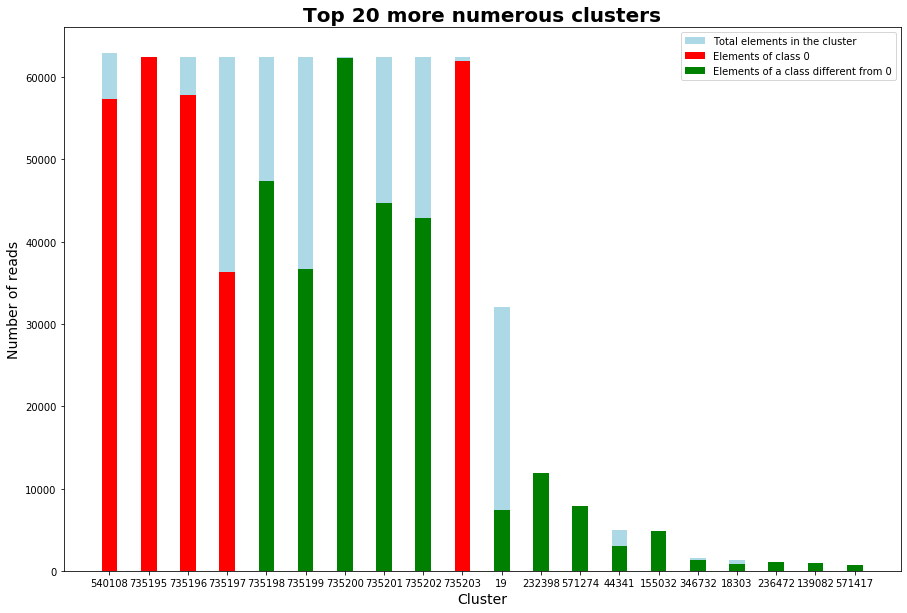

In [65]:
plt.figure(figsize=(15,10))

width = 0.4

plt.bar(topI,topTotalMax,width=width,color='lightblue',label='Total elements in the cluster')

name1 = 'Elements of class 0'
name2 = 'Elements of a class different from 0'

zeroCount = 0
notZeroCount = 0

for i in range(len(topClusterMax)):
    if topClusterMax[i] == '0':
        plt.bar(topI[i],topEqualMax[i],width=width,alpha=1,color='red',label=name1 if zeroCount==0 else '')
        zeroCount = zeroCount + 1
    else:
        plt.bar(topI[i],topEqualMax[i],width=width,alpha=1,color='green',label=name2 if notZeroCount==0 else '')
        notZeroCount = notZeroCount + 1



plt.xlabel('Cluster',fontsize=14)
plt.ylabel('Number of reads',fontsize=14)
plt.legend(loc='upper right')
plt.title('Top ' + str(top) + ' more numerous clusters',fontweight='bold',fontsize=20)

#### Classifier ensembles


In [6]:
def load_multi_classifier_result(path_list):

    classifiers_result = {}
    
    num_classifiers = len(path_list)
    
    for i in range (0, num_classifiers):
        
        classification = open(path_list[i], 'r')
        
        for line in classification: 
            col = []
            for j in range(0, len(line.split())):
                col.append(line.split()[j])
            
            if col[0] not in classifiers_result.keys():
                classifiers_result[col[0]] = []
                classifiers_result[col[0]].append(col[1])
            
            else:
                classifiers_result[col[0]].append(col[1])
        
        print("Classifier", i + 1, " of ", len(path_list), " loaded")
        classification.close()
        
    return classifiers_result

In [7]:
classifier_path_1 = "../../Bio_Project/SimDataset/classifiers_results/strex_clark_species_250000.res"
classifier_path_2 = "../../Bio_Project/SimDataset/classifiers_results/strex_centrifuge_250000.res"
classifier_path_3 = "../../Bio_Project/SimDataset/classifiers_results/strex_kraken2_250000.res"
classifier_path_4 = "../../Bio_Project/SimDataset/classifiers_results/strex_kraken1_250000.res"

path_list = []

path_list.append(classifier_path_1)
path_list.append(classifier_path_2)
path_list.append(classifier_path_3)
path_list.append(classifier_path_4)

start = time.time()
classifiers_result = load_multi_classifier_result(path_list)
end = time.time()

print("loading multi classifier:", end - start)

print(len(classifiers_result))

Classifier 1  of  4  loaded
Classifier 2  of  4  loaded
Classifier 3  of  4  loaded
Classifier 4  of  4  loaded
loading multi classifier: 46.17201089859009
3125000


In [8]:
i = 0
for key, value in classifiers_result.items():
    if (i < 10):
        print("key: ", key, end = ' ')
        print("value: ", value)
        i = i + 1
    else:
        break

key:  taxid_1042876.1 value:  ['76759', '76759', '76759', '76759']
key:  taxid_1042876.2 value:  ['76759', '76759', '76759', '76759']
key:  taxid_1042876.3 value:  ['303', '76759', '1215088', '1215088']
key:  taxid_1042876.4 value:  ['76759', '76759', '76759', '76759']
key:  taxid_1042876.5 value:  ['76759', '76759', '76759', '76759']
key:  taxid_1042876.6 value:  ['294', '1114970', '80840', '1114970']
key:  taxid_1042876.7 value:  ['76759', '76759', '76759', '76759']
key:  taxid_1042876.8 value:  ['303', '1215088', '1215088', '1215088']
key:  taxid_1042876.9 value:  ['76759', '76759', '76759', '76759']
key:  taxid_1042876.10 value:  ['76759', '76759', '76759', '76759']


In [9]:
dataset_path = "../../Bio_Project/SimDataset/reads_datasets/all_250000_1.fq"
clusters_path =  "../../Bio_Project/results/LiME_binning_all_250000_1/all_250000_1+RC.fasta.a16.t20.txt"

In [10]:
dataset_lines = load_dataset(dataset_path, False)
clusters_list = load_clusters_result(clusters_path)

In [11]:
start = time.time()
dataset = build_dataset(dataset_lines,clusters_list,classifiers_result)
end = time.time()
print("Time for loading the dataset ([read_id, [label_1, label_2,..., label_n], cluster_index]): ", end - start)

Time for loading the dataset ([read_id, [label_1, label_2,..., label_n], cluster_index]):  7.811858654022217


In [43]:
print(dataset[0])
print(dataset[200])

['taxid_1042876.1', ['76759', '76759', '76759', '76759'], 0]
['taxid_1042876.201', ['76759', '76759', '76759', '76759'], 197]


In [13]:
def get_generalized_inverted_index(clusters, dataset):

    num_clusters = max(clusters) + 1
    num_reads = len(dataset)
    inverted_index = []
    
    for i in range(0, num_clusters):
        inverted_index.append([])
   
    for i in range(0, num_reads):
        for j in range(0, len(dataset[i][1])):
            inverted_index[dataset[i][2]].append(dataset[i][1][j])

    return inverted_index

In [14]:
start = time.time()
inverted_index = get_generalized_inverted_index(clusters_list, dataset)
stop = time.time()

print("Inverted index created in time: ", stop - start)

Inverted index created in time:  7.404241561889648


In [44]:
print(len(inverted_index))
print(inverted_index[0])
print(inverted_index[197])

735204
['76759', '76759', '76759', '76759']
['76759', '76759', '76759', '76759', '76759', '76759', '76759', '76759', '76759', '76759', '76759', '76759', '76759', '286', '76759', '76759']


In [18]:
start = time.time()
i = 0
max_label_per_cluster_list = []
max_label_list = []
for cluster in inverted_index:
    label_dict = frequency_search(cluster)
    max_label = ""
    max_count = 0
    for label, count in label_dict.items():
        #print(label, count)
        if (count > max_count):
            max_count = count
            max_label = label
    #print("CLUSTER: ", i, " MAX_LABEL: ", max_label, "MAX COUNT: ", max_count, "CLUSTER LENGTH: ", len(cluster))
    max_label_list.append(max_label)
    max_label_per_cluster_list.append([max_label, max_count, len(cluster)])
    i = i + 1

TotalReassignment = True
#Choose the type of reassignment
if TotalReassignment:
    reassigned_classification = total_reassignment(dataset, max_label_list) 
else:
    reassigned_classification = partial_reassignment(dataset, max_label_list) 
stop = time.time()


print("Classes have been elaborated in: ", stop - start)

Classes have been elaborated in:  21.356582403182983


In [19]:
f = open("multioutputfilespecies.res", "w")

for element in reassigned_classification:
    f.write(element[0])
    f.write("\t")
    f.write(str(element[1]))
    f.write("\n")
f.close()


#### Label assignment to each read based by considering the output of multiclassifiers --> voting rule: majority

#### PARITA' NON GESTITE --> MEGLIO L'ALTRA VERSIONE

In [23]:

def label_assignment(classifiers_result):

    classifier_ensamble = {}

    for read in classifiers_result.keys():
        
        labels = classifiers_result[read]
        label_dict = frequency_search(labels)
        
        max_frequency = - 1
        max_label = ''
        
        for label in label_dict.keys():
            if (label_dict[label] > max_frequency):
                max_label = label
                max_frequency = label_dict[label]
            
        classifier_ensamble[read] = max_label

    return classifier_ensamble
    

#### Debugging of label_assignment function

In [24]:
start = time.time()
classifier_ensamble = label_assignment(classifiers_result)
stop = time.time()

print("label_assignment function running time: ", stop - start)

label_assignment function running time:  13.4659903049469


In [45]:
i = 0
for key, value in classifier_ensamble.items():
    if (i < 20):
        print("key: ", key, end = ' ')
        print("value: ", value)
        i = i + 1
    else:
        break        

key:  taxid_1042876.1 value:  76759
key:  taxid_1042876.2 value:  76759
key:  taxid_1042876.3 value:  1215088
key:  taxid_1042876.4 value:  76759
key:  taxid_1042876.5 value:  76759
key:  taxid_1042876.6 value:  1114970
key:  taxid_1042876.7 value:  76759
key:  taxid_1042876.8 value:  1215088
key:  taxid_1042876.9 value:  76759
key:  taxid_1042876.10 value:  76759
key:  taxid_1042876.11 value:  76759
key:  taxid_1042876.12 value:  76759
key:  taxid_1042876.13 value:  76759
key:  taxid_1042876.14 value:  1196325
key:  taxid_1042876.17 value:  76759
key:  taxid_1042876.18 value:  76759
key:  taxid_1042876.20 value:  76759
key:  taxid_1042876.21 value:  76759
key:  taxid_1042876.22 value:  303
key:  taxid_1042876.23 value:  76759


#### PARITA' GESTITA --> DA TENERE

In [40]:
# generate random integer values
from random import seed
from random import randint

# seed random number generator
seed(1)

def label_assignment_generalized(classifiers_result):

    classifier_ensamble = {}

    for read in classifiers_result.keys():
        
        labels = classifiers_result[read]
        label_dict = frequency_search(labels)
        
        max_frequency = - 1
        
        for label in label_dict.keys():
            if (label_dict[label] >= max_frequency):
                max_frequency = label_dict[label]
            
        max_labels = []
        for label in label_dict.keys():
            if label_dict[label] == max_frequency:
                max_labels.append(label)
        
        if len(max_labels) == 1:
                classifier_ensamble[read] = max_labels[0]
        
        else:
            value = randint(0, len(max_labels) - 1)
            classifier_ensamble[read] = max_labels[value]

    return classifier_ensamble

#### Debugging of label_assignment_generalized function

In [41]:
start = time.time()
classifier_ensamble_if_ties = label_assignment_generalized(classifiers_result)
stop = time.time()

print("label_assignment_generalized function running time: ", stop - start)

label_assignment_generalized function running time:  19.482075452804565


In [46]:
i = 0
for key, value in classifier_ensamble_if_ties.items():
    if (i < 20):
        print("key: ", key, end = ' ')
        print("value: ", value)
        i = i + 1
    else:
        break   

key:  taxid_1042876.1 value:  76759
key:  taxid_1042876.2 value:  76759
key:  taxid_1042876.3 value:  1215088
key:  taxid_1042876.4 value:  76759
key:  taxid_1042876.5 value:  76759
key:  taxid_1042876.6 value:  1114970
key:  taxid_1042876.7 value:  76759
key:  taxid_1042876.8 value:  1215088
key:  taxid_1042876.9 value:  76759
key:  taxid_1042876.10 value:  76759
key:  taxid_1042876.11 value:  76759
key:  taxid_1042876.12 value:  76759
key:  taxid_1042876.13 value:  76759
key:  taxid_1042876.14 value:  1196325
key:  taxid_1042876.17 value:  76759
key:  taxid_1042876.18 value:  76759
key:  taxid_1042876.20 value:  76759
key:  taxid_1042876.21 value:  76759
key:  taxid_1042876.22 value:  303
key:  taxid_1042876.23 value:  76759
